# Continuación clase método de la transformada inversa

In [8]:
# Librería de optimización 
from scipy import optimize
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# %matplotlib notebook
%matplotlib inline

### Función para crear histograma de distribuciones discretas

In [3]:
def Gen_distr_discreta(p_acum: 'P.Acumulada de la distribución a generar',
                       indices: 'valores reales a generar aleatoriamente',
                       N: 'cantidad de números aleatorios a generar'):
    
    U =np.random.rand(N)
    # Diccionario de valores aleatorios
    rand2reales = {i: idx for i, idx in enumerate(indices)}

    # Series de los valores aletorios
    y = pd.Series([sum([1 for p in p_acum if p < ui]) for ui in U]).map(rand2reales)

    return y

In [52]:
def plot_histogram_discrete(distribucion:'señal de varibles aleatorias de un distribución DISCRETA dada',
                            label:'label del legend a aparecer en el gráfica',
                            densidad:'por defecto regresa el histograma en densidad'=True):
    # len(set(distribucion)) cuenta la cantidad de elementos distintos de la variable 'distribucion'
    plt.figure(figsize=[10,4])
    y, x = np.histogram(distribucion, bins=len(set(distribucion)), density=densidad) 
    plt.bar(x[1:], y, label=label)
    plt.legend()
    plt.show()

### Ejemplo binomial: 
La distribución binomial modela el número de éxitos de n ensayos independientes donde hay una probabilidad p de éxito en cada ensayo.

Generar una variable aletoria binomial con parámetros $n=10$ y $p=0.7$. Recordar que
$$X\sim binomial(n,p) \longrightarrow p_i=P(X=i)=\frac{n!}{i!(n-i)!}p^i(1-p)^{n-i},\quad i=0,1,\cdots,n$$
> ## <font color ='red'>Tarea: Demostrar la validez de la siguiente ecuación
>$$p_{i+1}=\frac{n-i}{i+1}\frac{p}{1-p} p_i \longrightarrow \text{Hablar de las ventajas que sea recursiva}$$

**El Algoritmo que debemos realizar:**
   1. Generar $U$.
   2. Si $U<p_0$, poner $X=0$ y detenerse.
   3. Si $p_0<U<p_0+p_1$, poner $X=1$ y detenerse.
   $$ \vdots$$
   4. Si $p_0+\cdots+p_{n-1}<U<p_0+\cdots+p_{n}$, poner $X=n$ y detenerse.

In [5]:
# Función que calcula la probabilidad acumulada optimizada
def P_acum_Binomial_o(n,p):
    Pr = np.zeros(n)
    Pr[0] = (1-p)**n
    def pr(i):
        nonlocal Pr
        c  = p/(1-p)
        Pr[i+1]=(c*(n-i)/(i+1))*Pr[i]
        
    # Lleno el vector Pr usando compresión de listas
    [pr(i) for i in range(n-1)]
    return np.cumsum(Pr)

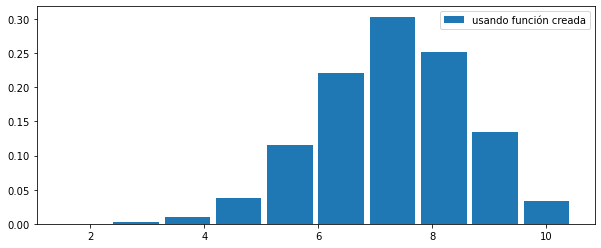

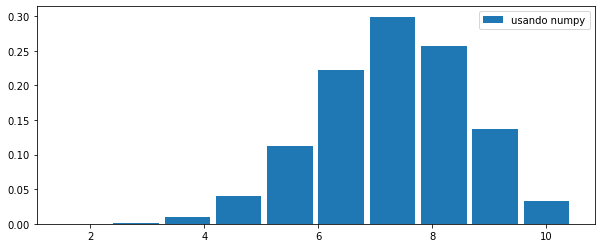

In [53]:
# def D_binomial_intermedia(n,p,N):
n = 10; p = 0.7; N = 10**4

p_acum = P_acum_Binomial_o(n,p)

# Usando el método de la transformada inversa
d_binomial = Gen_distr_discreta(p_acum, np.arange(0, n+1), N)

# Usando numpy
d_bino_numpy = np.random.binomial(n,p,N)


Explore el funcionamiento del siguiente comando

In [ ]:
list(set(d_binomial))

> ## <font color ='red'>Tarea
Seguir un procedimiento similar al mostrado cuando se generó una distribución binomial, pero en esta caso genere un código que genere variables aletorias Poisson cuya función de distribución de probabilidad esta dada por:
>$$P(k,\lambda)=\frac{e^{-\lambda}(\lambda)^k}{k!}$$
    
> Demuestre matemáticamente que 
> $$P(k+1)=\frac{\lambda}{k+1}P(k)$$
> y a partir de esta relación genere variables aletorias que distribuyen poisson usando el método de la transformada inversa.

Enlace: https://es.wikipedia.org/wiki/Distribuci%C3%B3n_de_Poisson

$
\begin{aligned}
\frac{p_{k+1}}{p_k}& = \frac{e^{-\lambda}(\lambda)^k}{k!} \\
& = \frac{e^{-\lambda}(\lambda)^k}{k!}
\end{aligned}
$

# Método de aceptación rechazo

Este método surgió debido a que muchas distribuciones continuas, no era factible aplicar el método de transformación inversa porque $x= F^{-1}(U)$ no se puede calcular (o al menos no es computacionalmente eficientemente).Con frecuencia, estos métodos son considerablemente más rápidos que el método de transformación inversa. Ahora ilustramos el **método de aceptación y rechazo** en un ejemplo simple.

Suponga que tenemos una función de densidad de probabilidad (PDF) de una distribución beta, la cual viene dada:
$$f(x)=\frac{x^{\alpha_1-1}(1-x)^{\alpha_2-1}}{B(\alpha_1,\alpha_2)} \quad x\in[0,1] \longrightarrow B(\alpha_1,\alpha_2)\equiv \int_{0}^{1}x^{\alpha_1-1}(1-x)^{\alpha_2-1}, \ \alpha_1,\alpha_2>1$$

**Hablar de las desventajas**

Ahora definiremos formalmente el método:

Note que $f(x)$ debe ser una **función acotada y con dominio finito**  $a\leq x \leq b$ como se muestra a continuación:
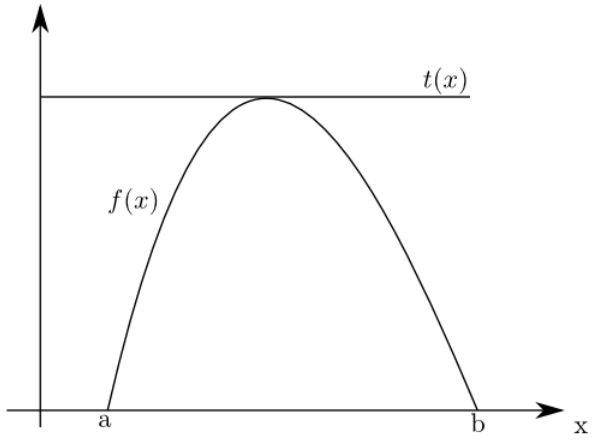

De acuerdo a esta función $f(x)$ el método propone los siguientes pasos. Asuma que podemos encontrar una función $t(x)$ tal que
$$t(x)\geq f(x), \quad \forall x$$
Note que la función $t(x)\geq 0$  no es una PDF debido a 
$$\int_{-\infty}^{\infty}t(x)dx\geq \int_{-\infty}^{\infty}f(x)dx =1$$
Tomemos
$$c=\int_{-\infty}^{\infty}t(x)\geq 1$$
Definamos la función $g(x)=t(x)/c \rightarrow g(x)$ **es una densidad**. Resultando entonces 
$$\frac{f(x)}{g(x)}\leq c,\quad \forall x$$
El siguiente algoritmo genera una variable aleatoria $X$, distribuida de acuerdo a la densidad $f(x)$
   1. Generar $R_1$ teniendo densidad $g(x)$ 
   2. Generar $R_2 \rightarrow U \sim U(0,1)$ independiente de $R_1$ del paso 1 .
   3. Evaluar la función de probabilidad en $R_1$.
   4. Determinar si la siguiente desigualdad se cumple: $$R_2\leq \frac{f(R_1)}{t(R_1)}$$
   Si la respuesta es afirmativa se utiliza $X=R_1$, de lo contrario es necesario pasar nuevamente al paso 1, tantas veces como sea necesario.

> Se puede demostrar que la $P(aceptar)=1/c$

### Ejemplo 1: Función beta

$$f(x; a,b) = \frac{1}{B(\alpha, \beta)} x^{\alpha - 1}
                                                 (1 - x)^{\beta - 1}$$

###  a). Caso particular: $\alpha=\beta=3$
Con estos valores la PDF es 
$$f(x)=30(x^2-2x^3+x^4)$$

In [2]:
# Función de aceptación y rechazo usando for
def Acep_rechazo2(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x = f(R1)
    t_x = t(R1)
    condition = R2*t_x <=f_x
    for i in range(len(R1)):
        if condition[i]:
            plt.plot(R1[i],R2[i]*t_x[i],'ob')
        else:
            plt.plot(R1[i],R2[i]*t_x[i],'o')
    plt.show()

In [54]:
# Función de aceptación y rechazo usando compresión de listas
def Acep_rechazo(R2:'Variables distruidas U~U(0,1)',
                 R1:'Variables distribuidas como g(x)',
                 f:'función objetivo a generar',
                 t:'función que mayora a f'):
#     R1 = np.random.rand(N)
    f_x = f(R1)
    t_x = t(R1)
    condition = R2*t_x <=f_x
    [plt.plot(R1[i],R2[i]*t_x[i],'ob') if condition[i] else plt.plot(R1[i],R2[i]*t_x[i],'o') \
         for i in range(len(R1))]
                
    plt.show()

El máximo de f es: [1.875]


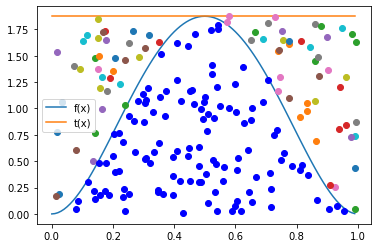

In [56]:
# Ilustración del método de aceptación y rechazo cuando se toma t(x) constante

# Función objetivo 
f = 
# Máximo de la función f
max_f = f(optimize.fmin(lambda x:-f(x), 0, disp=False))
# Función t -> Función constante
t = 

# Rango donde se graficará las funciones
x = 
print('El máximo de f es:',max_f)

# Gráficas de las funciones
plt.plot(x,f(x),label='f(x)')
plt.plot(x,t(x),label='t(x)')
plt.legend()

# Validación del método
N = 200 # número de puntos a simular
# Como estoy tomando t(x) constante solo es necesario generar valores aleatorios U~(0,1)
R2 = 
R1 = 

# Prueba de función creada

###  b). Caso general: $\alpha,\beta>0$ 

El máximo de la función es: 3.5848168690361635


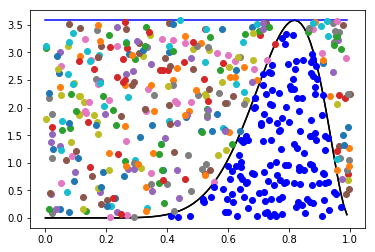

In [4]:
# Parámetros de la función beta
a =10; b=3
N = 500  # número de puntos
# Función objetivo
f = lambda x: beta.pdf(x,a,b)
x = np.arange(0,1,0.01)
plt.plot(x,f(x),'k')
# Encuentro el máximo de la función f
c = float(f(optimize.fmin(lambda x:-f(x),0,disp=False)))
print('El máximo de la función es:',c)

t = lambda x: c*np.ones(len(x))
plt.plot(x,f(x),'k')
plt.plot(x,t(x),'b')
R2 = np.random.rand(N)
R1 = np.random.rand(N)

Acep_rechazo(R2,R1,f,t)

plt.show()

# Tarea 
Partiendo que se desea generar variables aleatorias para la siguiente función de densidad
$$f(x)=30(x^2-2x^3+x^4)$$
Responda los siguientes literales:
1. Usar como función que mayora a $f(x)$ a $t(x)=a \sin(\pi x)$ donde a es el máximo de la función $f(x)$ y graficarlas en una misma gráfica, para validar que en realidad si cumple la condición $t(x)\geq f(x)$.
2. Encontrar la función de densidad $g(x)$ según lo visto en clase. Reportar todos los cálculos realizados para encontrar dicha función usando Markdown (Latex).
3. Usar la función encontrada en el punto 2 y utilizar el método de la transformada inversa visto en la clase 9, para generar variables aleatorias que sigan la distribución $g(x)$. **Nota:** Recuerde que el método de la transformada inversa funciona con la distribución de probabilidad acumulada y no con su densidad. Nuevamente similar al punto anterior reportar todos los cálculos usando Markdown (Latex). 
4. Según el punto 3, generar 10000 puntos aleatorios que sigan la distribución $g(x)$ y comparar con su histograma para validar que los puntos generados siguen la distribución deseada. El resultado debe ser como sigue:
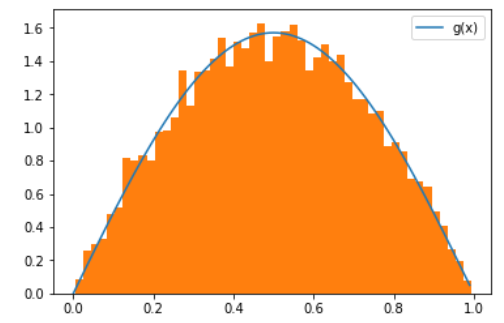

5. Genere 500 puntos aleatorios usando el método de aceptación y rechazo y las funciones $f(x)$ y $t(x)$ para validar que todos los cálculos anteriores están correctamente realizados. El resultado debe de ser como sigue:
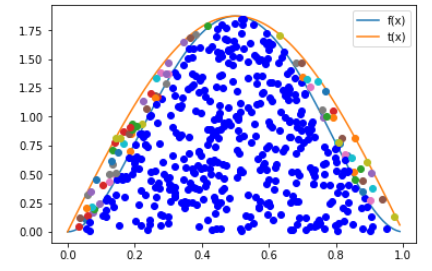

6. Comparar el porcentaje de puntos de aceptación cuando se usa $t(x)$ constante y $t(x)$ un pulso senoidal. Concluir

7. Genere una variable aleatoria $X$ a partir de la siguiente PDF
$$f(x)=20x(1-x)^3$$ 
usando el método de aceptación y rechazo

## Parámetros de entrega
Voy a habilitar un link en Canvas donde deben de subir su cuaderno de python con la sulución de los problemas planteados en parejas. La podrán entregar a mas tardar el martes 6 de octubre a las 6pm. Como será en parejas, deben de crear un proyecto conjunto en github y realizar los ejercicios de manera conjunta, de manera similar a como realizaron los ejercicios en la tarea 1. **Deben de poner en la solución de la tarea el enlace de github de el administrador del repositorio**, del cuál me basaré para poner la calificación.

# Solución Tarea

In [1]:
import numpy as np
import matplotlib.pyplot as plt

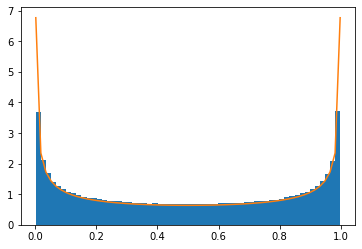

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Z.
</footer>